In [ ]:
# Install necessary libraries (only once)
!pip install torch torchvision datasets transformers scikit-learn matplotlib seaborn

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Load the 'ag_news' dataset from Hugging Face
dataset = load_dataset("ag_news")

# Let's check an example
print(dataset['train'][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [ ]:
# We'll use 'bert-base-uncased' for text embeddings
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()  # Set BERT in evaluation mode


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class AGNewsDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
        self.embeddings = self.generate_embeddings(texts)

    def generate_embeddings(self, texts):
        embeddings = []
        with torch.no_grad():
            for text in texts:
                inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
                inputs = {key: val.to(device) for key, val in inputs.items()}
                outputs = bert_model(**inputs)
                cls_embedding = outputs.last_hidden_state[:,0,:]  # Take the [CLS] token output
                embeddings.append(cls_embedding.squeeze(0).cpu().numpy())
        return np.array(embeddings)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx]


In [ ]:
# Use a smaller subset for faster processing (optional for Colab)
sample_size = 5000  # You can change this number

# Correct way: select a subset properly
subset = dataset['train'].select(range(sample_size))

# Now extract the text field
texts = [item['text'] for item in subset]

# Create dataset
agnews_dataset = AGNewsDataset(texts)


In [ ]:
batch_size = 64

data_loader = DataLoader(agnews_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=768, embedding_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [ ]:
input_dim = 768
embedding_dim = 64
learning_rate = 0.001
epochs = 20

model = Autoencoder(input_dim=input_dim, embedding_dim=embedding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in data_loader:
        batch = batch.to(device).float()

        optimizer.zero_grad()
        embeddings, outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}")


Epoch [1/20], Loss: 0.0906
Epoch [2/20], Loss: 0.0475
Epoch [3/20], Loss: 0.0389
Epoch [4/20], Loss: 0.0345
Epoch [5/20], Loss: 0.0318
Epoch [6/20], Loss: 0.0299
Epoch [7/20], Loss: 0.0285
Epoch [8/20], Loss: 0.0274
Epoch [9/20], Loss: 0.0265
Epoch [10/20], Loss: 0.0257
Epoch [11/20], Loss: 0.0251
Epoch [12/20], Loss: 0.0244
Epoch [13/20], Loss: 0.0239
Epoch [14/20], Loss: 0.0234
Epoch [15/20], Loss: 0.0230
Epoch [16/20], Loss: 0.0227
Epoch [17/20], Loss: 0.0225
Epoch [18/20], Loss: 0.0222
Epoch [19/20], Loss: 0.0219
Epoch [20/20], Loss: 0.0218


In [ ]:
# Switch model to eval mode
model.eval()

# Extract embeddings
all_embeddings = []

with torch.no_grad():
    for batch in data_loader:
        batch = batch.to(device).float()
        embeddings, _ = model(batch)
        all_embeddings.append(embeddings.cpu().numpy())

all_embeddings = np.vstack(all_embeddings)
print("Shape of all embeddings:", all_embeddings.shape)


Shape of all embeddings: (5000, 64)


In [ ]:
# Apply KMeans
n_clusters = 4  # AG News has 4 categories
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

print("Cluster labels:", cluster_labels[:10])


Cluster labels: [2 3 3 2 2 3 2 2 0 0]


In [ ]:
# Calculate evaluation metrics
silhouette = silhouette_score(all_embeddings, cluster_labels)
db_index = davies_bouldin_score(all_embeddings, cluster_labels)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")


Silhouette Score: 0.0643
Davies-Bouldin Index: 3.2711


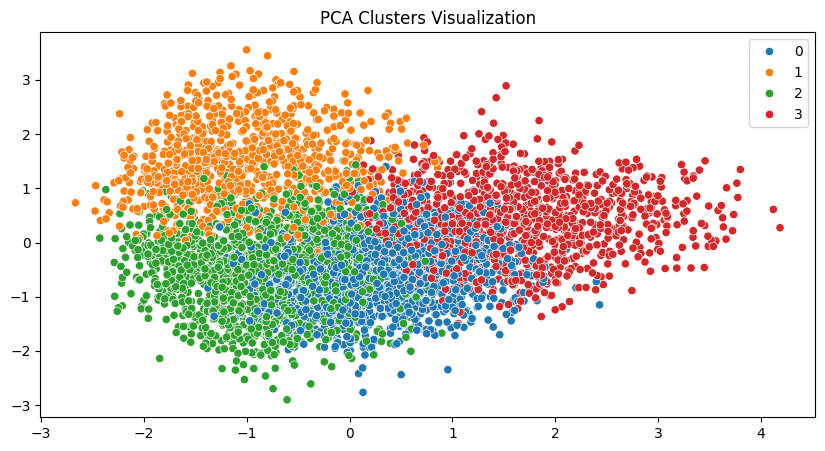

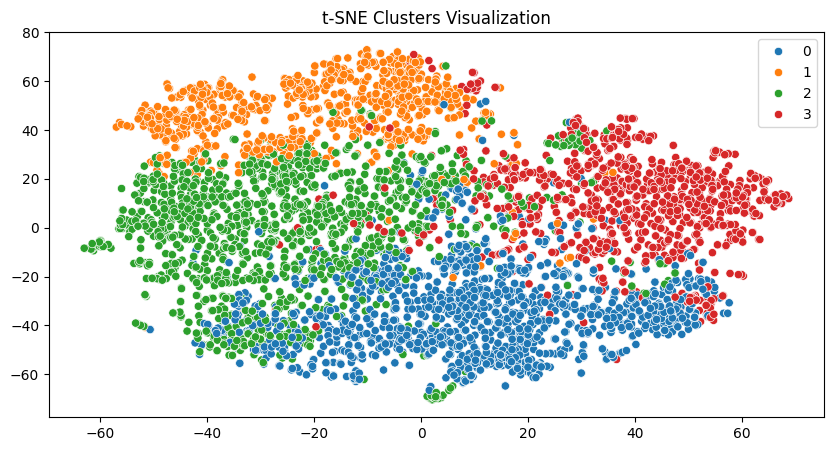

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)

# t-SNE can give better separation visually (optional, slower)
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_embeddings[:,0], y=pca_embeddings[:,1], hue=cluster_labels, palette="tab10")
plt.title("PCA Clusters Visualization")
plt.show()

# Plot t-SNE
plt.figure(figsize=(10,5))
sns.scatterplot(x=tsne_embeddings[:,0], y=tsne_embeddings[:,1], hue=cluster_labels, palette="tab10")
plt.title("t-SNE Clusters Visualization")
plt.show()
